# MNIST

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys
%cd /content/drive/MyDrive/Colab_Notebooks
os.getcwd()

/content/drive/MyDrive/Colab_Notebooks


'/content/drive/MyDrive/Colab_Notebooks'

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras.models import load_model
from lib import gan

import numpy as np
import argparse
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
def build_and_train_models():
    (x_train, _), (_, _) = mnist.load_data()
    
    # Reshape & Normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32')/255
    
    model_name = 'lsgan_mnist'
    
    # Network Params
    latent_size = 100 # z-vector dimension
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    # In Keras 2.11.0, 'decay' argument changed to 'weight_decay'
    # Discriminator model
    inputs = keras.Input(shape=input_shape, name='discriminator_input')
    discriminator = gan.discriminator(inputs, activation=None)
    # discriminator = build_discriminator(inputs)
    optimizer = RMSprop(learning_rate=lr, weight_decay=decay)
    discriminator.compile(loss='mse',
                          optimizer=optimizer,
                          metrics=['accuracy']
                         )
    discriminator.summary()
    
    # Generator model
    input_shape = (latent_size, )
    inputs = keras.Input(shape=input_shape, name='z_input')
    generator = gan.generator(inputs, image_size)
    generator.summary()
    
    # Adversarial model
    optimizer = RMSprop(learning_rate=lr*0.5, weight_decay=decay*0.5,)
    discriminator.trainable = False
    ## Adversarial = Generator + Discriminator
    adversarial = Model(inputs, discriminator(generator(inputs)), name=model_name)
    adversarial.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['accuracy']
                       )
    adversarial.summary()
    
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    gan.train(models, x_train, params)

In [6]:
if __name__=='__main__':
    build_and_train_models()

36520: [discriminator loss: 0.168108, acc: 0.789062] [adversarial loss: 0.434616, acc: 0.234375]
2/2 [==============================] - 0s 29ms/step
36521: [discriminator loss: 0.153909, acc: 0.789062] [adversarial loss: 0.571968, acc: 0.140625]
2/2 [==============================] - 0s 63ms/step
36522: [discriminator loss: 0.178329, acc: 0.742188] [adversarial loss: 0.325703, acc: 0.546875]
2/2 [==============================] - 0s 46ms/step
36523: [discriminator loss: 0.187238, acc: 0.765625] [adversarial loss: 0.725818, acc: 0.062500]
2/2 [==============================] - 0s 47ms/step
36524: [discriminator loss: 0.188222, acc: 0.710938] [adversarial loss: 0.396955, acc: 0.390625]
2/2 [==============================] - 0s 46ms/step
36525: [discriminator loss: 0.158613, acc: 0.804688] [adversarial loss: 0.434248, acc: 0.281250]
2/2 [==============================] - 0s 58ms/step
36526: [discriminator loss: 0.174677, acc: 0.742188] [adversarial loss: 0.374014, acc: 0.390625]
2/2 [====

KeyboardInterrupt: ignored

2023-02-26 20:17:11.301626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


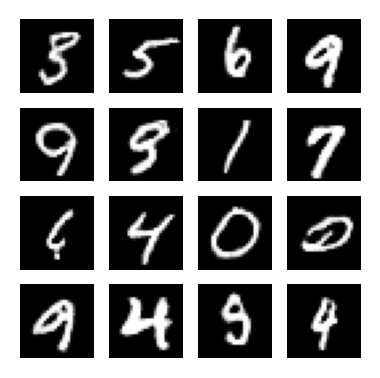

In [5]:
from keras.models import load_model

generator = load_model("./lsgan_mnist_30000.h5")
noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
gan.plot_images(generator,
                noise_input=noise,
                show=True,
                model_name="test_image"
               )